# Compare Two Imputation Methods

#### allele frequency data inevitably has missing values for some samples - 
#### the question is should we impute the values with the mean or use the lower allele frequency values that we know are censored

Mean impute - The imputed value is the mean allele frequency at that site <br>
Censor impute - The imputed value is the mean between 0 and 0.19 = 0.095 <br> 

Fortunately, we have allele frequencies before filtration so we can use each method to impute then compare with the values to get some idea of which method is better <br>

In [1]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from tqdm import tqdm
from itertools import zip_longest
from Statistics import elbow_detection
from Helpers.command_line import count_lines_in_file
from Helpers.pandasTools import join_columns
from sklearn.metrics import mean_squared_error

graph.style.use('fivethirtyeight')

loseq_path = '/data4/pipeline_ouputs/loseq/5171_loseq.vcf'
vcf_path = '/data4/pipeline_ouputs/snps/5171_snp_R3_final.vcf'

/home/harshil/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
loseq = pd.read_csv(loseq_path, comment='#', sep='\t', dtype={0: object}, header=None)
loseq.columns = ['chrom', 'pos', 'random', 'ref', 'alt', 'qual', 'filter', 'info']
loseq['index'] = join_columns(loseq['chrom'], loseq['pos'], loseq['ref'], loseq['alt'])

only_snps = loseq[(loseq['ref'].str.len() == 1) & (loseq['alt'].str.len() == 1)]
only_snps['sb'] = only_snps['info'].str.split(';').str.get(2).str.split('=').str.get(1).astype(int)
only_snps['dp'] = only_snps['info'].str.split(';').str.get(0).str.split('=').str.get(1).astype(int)
only_snps.head()

/home/harshil/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/harshil/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,chrom,pos,random,ref,alt,qual,filter,info,index,sb,dp
0,1.1,1116,.,T,A,288,PASS,"DP=97;AF=0.360825;SB=6;DP4=32,30,13,22",1.1:1116:T:A,6,97
2,1.1,1152,.,G,A,522,PASS,"DP=83;AF=0.506024;SB=9;DP4=13,11,14,28",1.1:1152:G:A,9,83
3,1.1,1348,.,C,T,476,PASS,"DP=58;AF=0.620690;SB=0;DP4=11,11,19,17",1.1:1348:C:T,0,58
4,1.1,1523,.,A,T,1352,PASS,"DP=59;AF=0.983051;SB=0;DP4=0,0,26,32",1.1:1523:A:T,0,59
5,1.1,1834,.,T,C,121,PASS,"DP=60;AF=0.166667;SB=0;DP4=26,23,5,5",1.1:1834:T:C,0,60


In [3]:
total_lines = count_lines_in_file('merged-925-R2-filtered-0.2af-0.0missing-1step.pvcf')

In [4]:
indices = []
means = []

with open('merged-925-R2-filtered-0.2af-0.0missing-1step.pvcf') as pvcf:
    headers = next(pvcf).strip().split('\t')
    
    for line in tqdm(pvcf, total=total_lines):
        line = line.strip().split('\t')
        index = ':'.join(line[:4]) 
        
        for colony, af in zip_longest(headers, line, fillvalue=''):
            if af == '' and colony == '5171':
                means.append(np.array([float(af) for af in line[4:] if af != '']).mean())
                indices.append(index)

100%|█████████▉| 691986/691987 [02:40<00:00, 4306.46it/s]


/home/harshil/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.20541116611661167


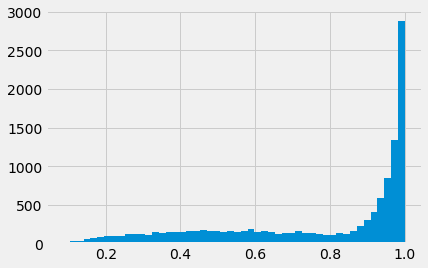

In [5]:
filtered = only_snps[only_snps['index'].isin(indices)]
filtered['af'] = filtered['info'].str.split(';').str.get(1).str.split('=').str.get(1).astype(float)

print(len(filtered) / len(indices))

graph.hist(filtered['af'], bins=50)
graph.show()

In [6]:
indices = []
means = []

with open('merged-925-R2-filtered-0.2af-0.0missing-1step.pvcf') as pvcf:
    headers = next(pvcf).strip().split('\t')
    
    for line in tqdm(pvcf, total=total_lines):
        line = line.strip().split('\t')
        index = ':'.join(line[:4]) 
        
        for colony, af in zip_longest(headers, line, fillvalue=''):
            if af == '' and colony == '5171' and index in filtered['index'].values:
                means.append(np.array([float(af) for af in line[4:] if af != '']).mean())
                indices.append(index)

100%|█████████▉| 691986/691987 [03:03<00:00, 3770.18it/s]


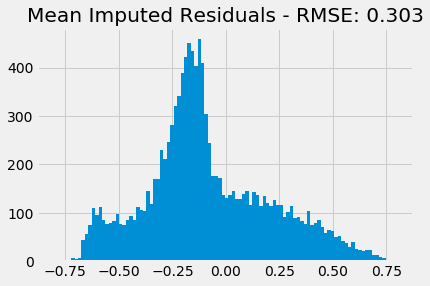

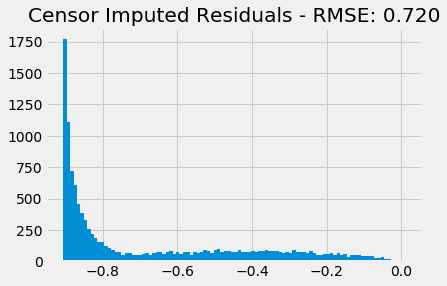

In [7]:
mean_impute = np.array(means) 
censor_impute = np.ones(len(filtered)) * 0.095 

mean_imputed_error = np.sqrt(mean_squared_error(filtered['af'], mean_impute))
censor_imputed_error = np.sqrt(mean_squared_error(filtered['af'], censor_impute))

graph.hist(mean_impute - filtered['af'],  bins=100)
graph.title(f'Mean Imputed Residuals - RMSE: {mean_imputed_error:0.3f}')
graph.show()

graph.hist(censor_impute - filtered['af'], bins=100)
graph.title(f'Censor Imputed Residuals - RMSE: {censor_imputed_error:0.3f}')
graph.show()

#### Mean impute does a better job at filling in missing values

Lets compare the strand bias, quality, and depth between the removed SNPs and kept SNPs

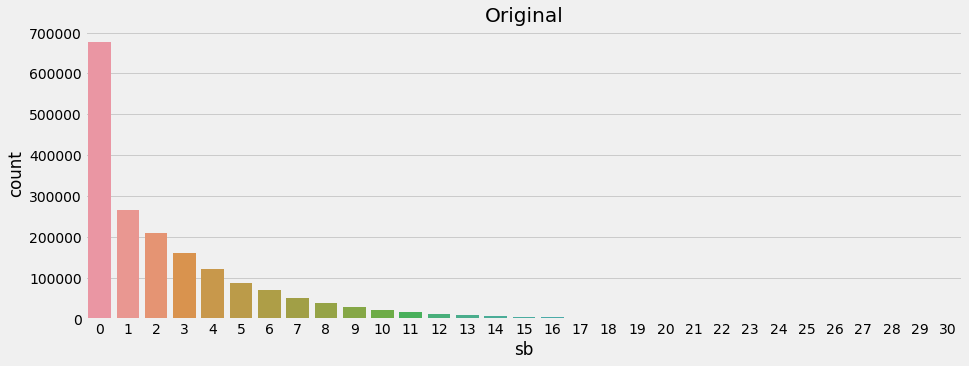

SNPs with strand bias >= 17 were filtered


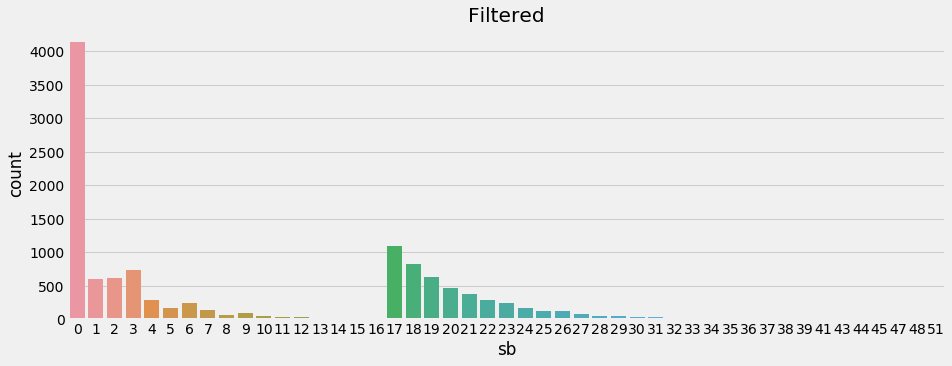

In [8]:
graph.figure(figsize=(14, 5))
sns.countplot(only_snps['sb'][only_snps['sb'] <= 30])
graph.title('Original')
graph.show()

print(f'SNPs with strand bias >= {elbow_detection(only_snps.sb)} were filtered')

graph.figure(figsize=(14, 5))
sns.countplot(filtered['sb'])
graph.title('Filtered')
graph.show()

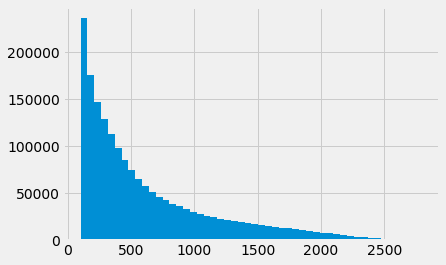

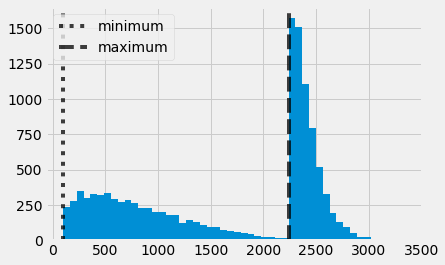

In [9]:
graph.hist(only_snps['qual'][only_snps['qual'] < 2800], bins=50)
graph.show()

graph.hist(filtered['qual'], bins=50)
graph.axvline(100, linestyle='dotted', color='black', alpha=0.75, label='minimum')
graph.axvline(elbow_detection(only_snps['qual']), linestyle='dashed', color='black', alpha=0.75, label='maximum')
graph.legend()
graph.show()

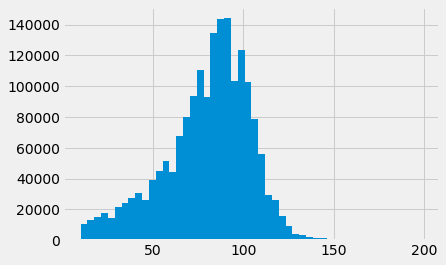

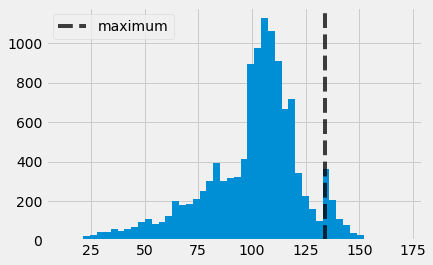

In [13]:
graph.hist(only_snps['dp'][only_snps['dp'] < 200], bins=50)
graph.show()

graph.hist(filtered['dp'], bins=50)
graph.axvline(elbow_detection(only_snps['dp']), linestyle='dashed', color='black', alpha=0.75, label='maximum')
graph.legend()
graph.show()